# Initialize Modules and Paths

In [16]:
# load modules

import numpy as np
import os
import h5py
from scipy.optimize import fsolve

import completeness

import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.serif'] = 'STIXGeneral'



In [2]:
# define paths

path_main = os.environ['WDIR_halo_model']
path_figures = path_main + 'Figures/'
path_DM_cat = path_main + 'catalogs/DM/'
path_SFH_cat = path_main + 'catalogs/SFH/'
path_SP_cat = path_main + 'catalogs/SP/'


In [3]:
# define important parameters

volume_box = 100.0**3  # in Mpc^-3




# Get Data from ody

In [3]:
# get the data in terminal

path_ody = '/n/eisenstein_lab/Users/stacchella/halo_model/catalogs/'

print 'scp stacchella@odyssey.rc.fas.harvard.edu:/' + path_ody + 'SFH/*.hdf5' + ' ' + path_SFH_cat
print 'scp stacchella@odyssey.rc.fas.harvard.edu:/' + path_ody + 'SP/*.hdf5' + ' ' + path_SP_cat



scp stacchella@odyssey.rc.fas.harvard.edu://n/eisenstein_lab/Users/stacchella/halo_model/catalogs/SFH/*.hdf5 /Users/sandrotacchella/ASTRO/JWST/halo_model/catalogs/SFH/
scp stacchella@odyssey.rc.fas.harvard.edu://n/eisenstein_lab/Users/stacchella/halo_model/catalogs/SP/*.hdf5 /Users/sandrotacchella/ASTRO/JWST/halo_model/catalogs/SP/


# Comparison UV LFs

In [14]:
# define functions

def compute_LF(SP_file_name, volume_box, cumulative=False, add_dust=False, redshift_in=None, completeness_correction=False):
    '''
    input:
      prop_list:    list of luminosities or masses
      prop_bins:    bins in which number density gets calculated
      volume_box:   box size for normalisation
    '''
    cat_SP = h5py.File(SP_file_name, 'r')
    mag_list = -48.6-2.5*np.log10(cat_SP['luminosities/luminosity_0'][:, 2]/(4*np.pi*(3.086e+19)**2))
    idx_good = np.isfinite(mag_list)
    mag_list = mag_list[idx_good]
    mag_bins = np.arange(np.max([-25.0, np.min(mag_list)]), np.min([-12.5, np.max(mag_list)]), 0.1)
    mag_bins_center = mag_bins[:-1] + 0.5*np.diff(mag_bins)
    if completeness_correction:
        weights = 10**completeness.get_completeness_correction(np.log10(cat_SP['DM/DM_M'][:][idx_good]), redshift_in)
    else:
        weights = None
    hist, bin_edges = np.histogram(mag_list, bins=mag_bins, weights=weights)
    if add_dust:
        mag_bins_center_d = add_dust_attenuation(mag_bins_center, redshift_in)
    else:
        mag_bins_center_d = mag_bins_center     
    if cumulative:
        LF = hist/volume_box
        return(mag_bins_center_d, LF)
    else:
        LFcum = np.cumsum(hist)/volume_box
        return(mag_bins_center_d, LFcum)


def get_dust_attenuation(magUV_in, redshift_in, with_scatter=False):
    '''
    This function computes the dust attenuation at 1600 A (A1600)
    from the Bouwens et al 2015 relation; used to do the dust 
    correction.
    '''
    # ensure inputs are arrays
    if type(magUV_in) is not np.ndarray:
        magUV_in = np.array([magUV_in])
    if type(redshift_in) is not np.ndarray:
        redshift_in = np.array([redshift_in])
    # values for beta-MUV relation from Bouwens et al 2015
    B15_z_list = np.array([2.5, 3.8, 5.0, 5.9, 7.0, 8.0])
    B15_beta_list = np.array([-1.70, -1.85, -1.91, -2.00, -2.05, -2.13])
    B15_dbdM_list = np.array([-0.20, -0.11, -0.14, -0.20, -0.20, -0.15])
    # interpolate beta-MUV relation
    beta_value = np.interp(redshift_in, B15_z_list, B15_beta_list, left=B15_beta_list[0], right=np.nan)
    dbdM_value = np.interp(redshift_in, B15_z_list, B15_dbdM_list, left=B15_dbdM_list[0], right=np.nan)
    # get average beta
    avg_b = dbdM_value*(magUV_in+19.5) + beta_value
    # convert beta to A1600
    if with_scatter:
        A1600 = 4.43 + 1.99*(avg_b + np.random.normal(loc=0.0, scale=0.34, size=len(avg_b)))
    else:
        A1600 = 4.43 + 0.2*np.log(10)*1.99**2*0.34**2+1.99*avg_b
    A1600[np.isnan(A1600)] = np.zeros(np.sum(np.isnan(A1600)))
    A1600[A1600 < 0.0] = np.zeros(np.sum(A1600 < 0.0))
    return(A1600)


def fct_solve(mag_with_dust, mag_without_dust, redshift):
    return(mag_without_dust-(mag_with_dust-get_dust_attenuation(mag_with_dust, redshift)))


def add_dust_attenuation(magUV_in, redshift_in, with_scatter=False):
    '''
    Adds dust according to the Bouwens et al 2015 relation.
    '''
    mag_with_dust = fsolve(fct_solve, magUV_in, args=(magUV_in, redshift_in))
    return(mag_with_dust)


def UV_LF_Bouwens15(mag_in, z, num_of_draws=1000, cumulative=True, do_dust_corr=True, with_scatter=False):
    '''
    This returns the UV LF (mags and phis) of Bouwens et al 2015.
    '''
    # take random draw from error distribution
    MUV_list = np.random.normal(loc=-20.95, scale=0.1, size=num_of_draws)+np.random.normal(loc=0.01, scale=0.06, size=num_of_draws)*(z-6.0)
    phi_list = np.random.normal(loc=0.47, scale=0.1, size=num_of_draws)*np.power(10, np.random.normal(loc=-0.27, scale=0.05, size=num_of_draws)*(z-6.0))*10**-3  # in Mpc
    alpha_list = np.random.normal(loc=-1.87, scale=0.05, size=num_of_draws)+np.random.normal(loc=-0.1, scale=0.03, size=num_of_draws)*(z-6.0)
    # print median
    print '---------------------'
    print 'redshift = ', z
    print 'MUV = ', np.round(np.median(MUV_list), 2)
    print 'phi (x10^-3) = ', np.round(np.median(phi_list)*10**3, 2)
    print 'alpha = ', np.round(np.median(alpha_list), 2)
    # correct for dust
    if do_dust_corr:
        AUV = get_dust_attenuation(mag_in, z, with_scatter=with_scatter)
        mag = mag_in - AUV
    else:
        mag = mag_in
    # get UV LF
    ii = 0
    UV_LF_list = phi_list[ii]*(np.log(10)/2.5)*np.power(10, -0.4*(mag_in-MUV_list[ii])*(alpha_list[ii]+1.0))*np.exp(-1.0*np.power(10.0, -0.4*(mag_in-MUV_list[ii])))
    for ii in np.arange(1, num_of_draws):
        UV_LF_ii = phi_list[ii]*(np.log(10)/2.5)*np.power(10, -0.4*(mag_in-MUV_list[ii])*(alpha_list[ii]+1.0))*np.exp(-1.0*np.power(10.0, -0.4*(mag_in-MUV_list[ii])))
        UV_LF_list = np.vstack([UV_LF_list, UV_LF_ii])
    UV_LF_median = np.percentile(UV_LF_list, 50, axis=0)
    UV_LF_P16 = np.percentile(UV_LF_list, 16, axis=0)
    UV_LF_P84 = np.percentile(UV_LF_list, 84, axis=0)
    if cumulative:
        UV_LF_cum_median = []
        UV_LF_cum_P16 = []
        UV_LF_cum_P84 = []
        for ii_mag in mag_in:
            idx = (mag_in < ii_mag)
            UV_LF_cum_median = np.append(UV_LF_cum_median, np.trapz(UV_LF_median[idx], mag_in[idx]))
            UV_LF_cum_P16 = np.append(UV_LF_cum_P16, np.trapz(UV_LF_P16[idx], mag_in[idx]))
            UV_LF_cum_P84 = np.append(UV_LF_cum_P84, np.trapz(UV_LF_P84[idx], mag_in[idx]))
        return(mag, UV_LF_cum_median, UV_LF_cum_P16, UV_LF_cum_P84)
    else:
        return(mag, UV_LF_median, UV_LF_P16, UV_LF_P84)


In [5]:
# make dictionary with observed LFs

LF_obs_dict = {}

# z=4
mag_list = np.array([-22.69, -22.19, -21.69, -21.19, -20.69, -20.19, -19.69, -19.19, -18.69, -18.19, -17.69, -16.94, -15.94])
phi_list = np.array([0.000003, 0.000015, 0.000134, 0.000393, 0.000678, 0.001696, 0.002475, 0.002984, 0.005352, 0.006865, 0.010473, 0.024580, 0.025080])
phi_err_list_neg = np.array([0.0000029, 0.000009, 0.000023, 0.000040, 0.000063, 0.000113, 0.000185, 0.000255, 0.000446, 0.001043, 0.002229, 0.003500, 0.007860])
phi_err_list_pos = np.array([0.000004, 0.000009, 0.000023, 0.000040, 0.000063, 0.000113, 0.000185, 0.000255, 0.000446, 0.001043, 0.002229, 0.003500, 0.007860])
LF_obs_dict['4'] = np.array([mag_list, phi_list, phi_err_list_neg, phi_err_list_pos])

# z=5
mag_list = np.array([-23.11, -22.61, -22.11, -21.61, -21.11, -20.61, -20.11, -19.61, -19.11, -18.36, -17.36, -16.36])
phi_list = np.array([0.000002, 0.000006, 0.000034, 0.000101, 0.000265, 0.000676, 0.001029, 0.001329, 0.002085, 0.004460, 0.008600, 0.024400])
phi_err_list_neg = np.array([0.0000019, 0.000003, 0.000008, 0.000014, 0.000025, 0.000046, 0.000067, 0.000094, 0.000171, 0.000540, 0.001760, 0.001760])
phi_err_list_pos = np.array([0.000002, 0.000003, 0.000008, 0.000014, 0.000025, 0.000046, 0.000067, 0.000094, 0.000171, 0.000540, 0.001760, 0.001760])
LF_obs_dict['5'] = np.array([mag_list, phi_list, phi_err_list_neg, phi_err_list_pos])

# z=6
mag_list = np.array([-22.52, -22.02, -21.52, -21.02, -20.52, -20.02, -19.52, -18.77, -17.77, -16.77])
phi_list = np.array([0.000002, 0.000015, 0.000053, 0.000176, 0.000320, 0.000698, 0.001246, 0.001900, 0.006680, 0.013640])
phi_err_list_neg = np.array([0.0000019, 0.000006, 0.000012, 0.000025, 0.000041, 0.000083, 0.000137, 0.000320, 0.001380, 0.004200])
phi_err_list_pos = np.array([0.000002, 0.000006, 0.000012, 0.000025, 0.000041, 0.000083, 0.000137, 0.000320, 0.001380, 0.004200])
LF_obs_dict['6'] = np.array([mag_list, phi_list, phi_err_list_neg, phi_err_list_pos])

# z=7
mag_list = np.array([-22.66, -22.16, -21.66, -21.16, -20.66, -20.16, -19.66, -19.16, -18.66, -17.91, -16.91])
phi_list = np.array([0.000002, 0.000001, 0.000033, 0.000048, 0.000193, 0.000309, 0.000654, 0.000907, 0.001717, 0.005840, 0.008500])
phi_err_list_neg = np.array([-99.0, 0.0000009, 0.000009, 0.000015, 0.000034, 0.000061, 0.000100, 0.000177, 0.000478, 0.001460, 0.002940])
phi_err_list_pos = np.array([-99.0, 0.000002, 0.000009, 0.000015, 0.000034, 0.000061, 0.000100, 0.000177, 0.000478, 0.001460, 0.002940])
LF_obs_dict['7'] = np.array([mag_list, phi_list, phi_err_list_neg, phi_err_list_pos])

# z=8
mag_list = np.array([-22.87, -22.37, -21.87, -21.37, -20.87, -20.37, -19.87, -19.37, -18.62, -17.62])
phi_list = np.array([0.000002, 0.000002, 0.000005, 0.000013, 0.000058, 0.000060, 0.000331, 0.000533, 0.001060, 0.002740])
phi_err_list = np.array([-99.0, -99.0, 0.000003, 0.000005, 0.000015, 0.000026, 0.000104, 0.000226, 0.000340, 0.001040])
LF_obs_dict['8'] = np.array([mag_list, phi_list, phi_err_list, phi_err_list])

# z=10
mag_list = np.array([-22.25, -21.25, -20.25, -19.25, -18.25, -17.25])
phi_list = np.array([0.017*10**-4, 0.010*10**-4, 0.100*10**-4, 0.340*10**-4, 1.900*10**-4, 6.300*10**-4])
phi_err_list_neg = np.array([-99.0, 0.008*10**-4, 0.050*10**-4, 0.220*10**-4, 1.200*10**-4, 5.200*10**-4])
phi_err_list_pos = np.array([-99.0, 0.022*10**-4, 0.100*10**-4, 0.450*10**-4, 2.500*10**-4, 14.90*10**-4])
LF_obs_dict['10'] = np.array([mag_list, phi_list, phi_err_list_neg, phi_err_list_pos])



In [52]:

[redshift]



array([[ -2.26600000e+01,  -2.21600000e+01,  -2.16600000e+01,
         -2.11600000e+01,  -2.06600000e+01,  -2.01600000e+01,
         -1.96600000e+01,  -1.91600000e+01,  -1.86600000e+01,
         -1.79100000e+01,  -1.69100000e+01],
       [  2.00000000e-06,   1.00000000e-06,   3.30000000e-05,
          4.80000000e-05,   1.93000000e-04,   3.09000000e-04,
          6.54000000e-04,   9.07000000e-04,   1.71700000e-03,
          5.84000000e-03,   8.50000000e-03],
       [ -9.90000000e+01,   9.00000000e-07,   9.00000000e-06,
          1.50000000e-05,   3.40000000e-05,   6.10000000e-05,
          1.00000000e-04,   1.77000000e-04,   4.78000000e-04,
          1.46000000e-03,   2.94000000e-03],
       [ -9.90000000e+01,   2.00000000e-06,   9.00000000e-06,
          1.50000000e-05,   3.40000000e-05,   6.10000000e-05,
          1.00000000e-04,   1.77000000e-04,   4.78000000e-04,
          1.46000000e-03,   2.94000000e-03]])

In [6]:
def plot_UV_LF_observations(axes, dictionary, redshift, color, label):
    idx_no_upper_limit = (dictionary[redshift][2]>0.0)
    idx_upper_limit = ~idx_no_upper_limit
    # plot errorbar
    error_bar_neg = np.log10(dictionary[redshift][1][idx_no_upper_limit])-np.log10(dictionary[redshift][1][idx_no_upper_limit]-dictionary[redshift][2][idx_no_upper_limit])
    error_bar_pos = np.log10(dictionary[redshift][1][idx_no_upper_limit]+dictionary[redshift][3][idx_no_upper_limit])-np.log10(dictionary[redshift][1][idx_no_upper_limit])
    axes.errorbar(dictionary[redshift][0][idx_no_upper_limit], np.log10(dictionary[redshift][1][idx_no_upper_limit]), yerr=[error_bar_neg, error_bar_pos], fmt='o', color=color, capsize=3, label=label)
    # plot upper limit
    axes.errorbar(dictionary[redshift][0][idx_upper_limit], np.log10(dictionary[redshift][1][idx_upper_limit]), yerr=0.4, fmt='.', markersize=0, color=color, capsize=3, uplims=True)



In [7]:
# get observed UV LF from Bouwens et al 2015

list_mag_in = np.linspace(-30.0, -15.0, num=1000)
list_mag_z4, UVLF_z4_median, UVLF_z4_P16, UVLF_z4_P84 = UV_LF_Bouwens15(list_mag_in, 4.0, num_of_draws=1000, cumulative=False, do_dust_corr=False)
list_mag_z6, UVLF_z6_median, UVLF_z6_P16, UVLF_z6_P84 = UV_LF_Bouwens15(list_mag_in, 6.0, num_of_draws=1000, cumulative=False, do_dust_corr=False)
list_mag_z8, UVLF_z8_median, UVLF_z8_P16, UVLF_z8_P84 = UV_LF_Bouwens15(list_mag_in, 8.0, num_of_draws=1000, cumulative=False, do_dust_corr=False)
list_mag_z10, UVLF_z10_median, UVLF_z10_P16, UVLF_z10_P84 = UV_LF_Bouwens15(list_mag_in, 10.0, num_of_draws=1000, cumulative=False, do_dust_corr=False)


---------------------
redshift =  4.0
MUV =  -20.97
phi (x10^-3) =  1.58
alpha =  -1.67
---------------------
redshift =  6.0
MUV =  -20.95
phi (x10^-3) =  0.46
alpha =  -1.87
---------------------
redshift =  8.0
MUV =  -20.92
phi (x10^-3) =  0.13
alpha =  -2.07
---------------------
redshift =  10.0
MUV =  -20.91
phi (x10^-3) =  0.04
alpha =  -2.27


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10


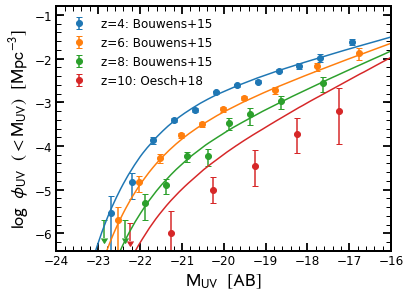

In [8]:
# test plotting of UV LF

redshift_plot = ['4', '6', '8', '10']
color_plot = ['C0', 'C1', 'C2', 'C3']
label_plot = ['z=4: Bouwens+15', 'z=6: Bouwens+15', 'z=8: Bouwens+15', 'z=10: Oesch+18']


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))

# plot data points from stepwise determination using SWML method
for ii in range(len(redshift_plot)):
    plot_UV_LF_observations(ax, LF_obs_dict, redshift_plot[ii], color_plot[ii], label_plot[ii])

# plot STY79 determinations of the Schechter Parameters (best fit from Bouwens)
# different from Oesch at z~10!
ax.plot(list_mag_z4, np.log10(UVLF_z4_median), '-', color=color_plot[0])
ax.plot(list_mag_z6, np.log10(UVLF_z6_median), '-', color=color_plot[1])
ax.plot(list_mag_z8, np.log10(UVLF_z8_median), '-', color=color_plot[2])
ax.plot(list_mag_z10, np.log10(UVLF_z10_median), '-', color=color_plot[3])
    

ax.set_xlabel(r'$\mathrm{M}_{\rm UV}\/\/\/\/[\mathrm{AB}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\phi_{\rm UV}\/\/\/\/(<\mathrm{M}_{\rm UV})\/\/\/\/[\mathrm{Mpc}^{-3}]$', fontsize=18)

ax.set_xlim([-24, -16])
ax.set_ylim([-6.4, -0.8])

plt.legend(frameon=False, fontsize=12)
plt.savefig(path_figures + 'UV_LF_test.pdf', bbox_inches='tight')
plt.show()

## Compare UV LFs 

In [9]:
# simple comparison with z=4 (where calibration was done)

cat_SP = h5py.File(path_SP_cat + 'SFH_z4_constant_with_L.hdf5', 'r')
mag_list = -48.6-2.5*np.log10(cat_SP['luminosities/luminosity_0'][:, 2]/(4*np.pi*(3.086e+19)**2))

if completeness_correction:
    weights = 10**completeness.get_completeness_correction(np.log10(cat_SP['DM/DM_M'][:]), redshift)
else:
    weights = None

mag_bins_center, LF = compute_LF(mag_list, volume_box, cumulative=False, add_dust=True, redshift_in=4.0)



In [17]:
mag_bins_center, LF = compute_LF(path_SP_cat + 'SFH_z4_constant_with_L.hdf5', volume_box, cumulative=False, add_dust=True, redshift_in=4.0, completeness_correction=True)


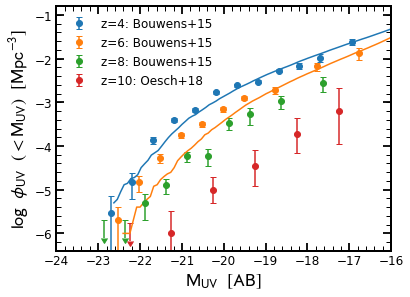

In [22]:
redshift_plot = ['4', '6', '8', '10']
color_plot = ['C0', 'C1', 'C2', 'C3']
label_plot = ['z=4: Bouwens+15', 'z=6: Bouwens+15', 'z=8: Bouwens+15', 'z=10: Oesch+18']


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))

# plot data points from stepwise determination using SWML method
for ii in range(len(redshift_plot)):
    plot_UV_LF_observations(ax, LF_obs_dict, redshift_plot[ii], color_plot[ii], label_plot[ii])


for ii in range(len(redshift_plot))[:2]:
    mag_bins_center, LF = compute_LF(path_SP_cat + 'SFH_z' + redshift_plot[ii] + '_constant_with_L.hdf5', volume_box, cumulative=False, add_dust=True, redshift_in=4.0, completeness_correction=True)
    ax.plot(mag_bins_center, np.log10(LF), '-', color=color_plot[ii])

    
ax.set_xlabel(r'$\mathrm{M}_{\rm UV}\/\/\/\/[\mathrm{AB}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\phi_{\rm UV}\/\/\/\/(<\mathrm{M}_{\rm UV})\/\/\/\/[\mathrm{Mpc}^{-3}]$', fontsize=18)

ax.set_xlim([-24, -16])
ax.set_ylim([-6.4, -0.8])

plt.legend(frameon=False, fontsize=12)
plt.savefig(path_figures + 'UV_LF_test_2.pdf', bbox_inches='tight')
plt.show()


In [107]:
# get observed UV LF from Bouwens et al 2015

list_mag_in = np.linspace(-30.0, -15.0, num=1000)
list_mag_z4, UVLF_z4_median, UVLF_z4_P16, UVLF_z4_P84 = UV_LF_Bouwens15(list_mag_in, 3.8, num_of_draws=1000, cumulative=True, do_dust_corr=True)
list_mag_z6, UVLF_z6_median, UVLF_z6_P16, UVLF_z6_P84 = UV_LF_Bouwens15(list_mag_in, 5.9, num_of_draws=1000, cumulative=True, do_dust_corr=True)
list_mag_z8, UVLF_z8_median, UVLF_z8_P16, UVLF_z8_P84 = UV_LF_Bouwens15(list_mag_in, 8, num_of_draws=1000, cumulative=True, do_dust_corr=True)
list_mag_z10, UVLF_z10_median, UVLF_z10_P16, UVLF_z10_P84 = UV_LF_Bouwens15(list_mag_in, 10, num_of_draws=1000, cumulative=True, do_dust_corr=True)


---------------------
redshift =  3.8
MUV =  -20.97
phi (x10^-3) =  1.83
alpha =  -1.65
---------------------
redshift =  5.9
MUV =  -20.95
phi (x10^-3) =  0.51
alpha =  -1.86
---------------------
redshift =  8
MUV =  -20.93
phi (x10^-3) =  0.13
alpha =  -2.07
---------------------
redshift =  10
MUV =  -20.91
phi (x10^-3) =  0.04
alpha =  -2.27


In [6]:
# simple comparison with z=4 (where calibration was done)


cat_z4_M10 = h5py.File(path_SP_cat + 'SFH_z4_constant_M10_with_L.hdf5', 'r')
cat_z4_M10 = h5py.File(path_SP_cat + 'SFH_z4_constant_with_L.hdf5', 'r')
cat_z4_M20 = h5py.File(path_SP_cat + 'SFH_z4_constant_M20_with_L.hdf5', 'r')
cat_z4_M33 = h5py.File(path_SP_cat + 'SFH_z4_constant_M33_with_L.hdf5', 'r')
cat_z4_M100 = h5py.File(path_SP_cat + 'SFH_z4_constant_M100_with_L.hdf5', 'r')

mag_list_M10 = -48.6-2.5*np.log10(cat_z4_M10['luminosities/luminosity_0'][:, 2]/(4*np.pi*(3.086e+19)**2))
mag_list_M20 = -48.6-2.5*np.log10(cat_z4_M20['luminosities/luminosity_0'][:, 2]/(4*np.pi*(3.086e+19)**2))
mag_list_M33 = -48.6-2.5*np.log10(cat_z4_M33['luminosities/luminosity_0'][:, 2]/(4*np.pi*(3.086e+19)**2))
mag_list_M100 = -48.6-2.5*np.log10(cat_z4_M100['luminosities/luminosity_0'][:, 2]/(4*np.pi*(3.086e+19)**2))

mag_bins_center_M10, cumLF_M10 = compute_cumulative_LF(mag_list_M10, volume_box)
mag_bins_center_M20, cumLF_M20 = compute_cumulative_LF(mag_list_M20, volume_box)
mag_bins_center_M33, cumLF_M33 = compute_cumulative_LF(mag_list_M33, volume_box)
mag_bins_center_M100, cumLF_M100 = compute_cumulative_LF(mag_list_M100, volume_box)

# plot information
print cat_z4_M33['luminosities/luminosity_0'].attrs['logzsol']
print cat_z4_M33['luminosities/luminosity_0'].attrs['IMF_name']
print cat_z4_M33['luminosities/luminosity_0'].attrs['IMF']


0.0
Salpeter
0.0


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10


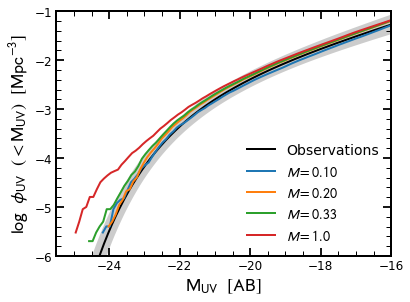

In [7]:
# check different descaling of efficiency in mergers at z=4

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))

ax.plot(list_mag_z4, np.log10(UVLF_z4_median), '-', color='black', lw=2, label='Observations')
ax.fill_between(list_mag_z4, np.log10(UVLF_z4_P16), np.log10(UVLF_z4_P84), color='black', lw=0.0, alpha=0.2)

ax.plot(mag_bins_center_M10, np.log10(cumLF_M10), '-', color='C0', lw=2, label=r'$M=0.10$')
ax.plot(mag_bins_center_M20, np.log10(cumLF_M20), '-', color='C1', lw=2, label=r'$M=0.20$')
ax.plot(mag_bins_center_M33, np.log10(cumLF_M33), '-', color='C2', lw=2, label=r'$M=0.33$')
ax.plot(mag_bins_center_M100, np.log10(cumLF_M100), '-', color='C3', lw=2, label=r'$M=1.0$')

ax.set_xlabel(r'$\mathrm{M}_{\rm UV}\/\/\/\/[\mathrm{AB}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\phi_{\rm UV}\/\/\/\/(<\mathrm{M}_{\rm UV})\/\/\/\/[\mathrm{Mpc}^{-3}]$', fontsize=18)

ax.set_xlim([-25.5, -16])
ax.set_ylim([-6.0, -1.0])

plt.legend(frameon=False, fontsize=14)
#plt.savefig(path_figures + 'UV_LF_z4_diffM.pdf', bbox_inches='tight')
plt.show()


In [8]:
# plot observations vs model for different redshifts

cat_z4 = h5py.File(path_SP_cat + 'SFH_z4_constant_with_L.hdf5', 'r')
cat_z6 = h5py.File(path_SP_cat + 'SFH_z6_constant_with_L.hdf5', 'r')
cat_z8 = h5py.File(path_SP_cat + 'SFH_z8_constant_with_L.hdf5', 'r')
cat_z10 = h5py.File(path_SP_cat + 'SFH_z10_constant_with_L.hdf5', 'r')

mag_list_z4 = -48.6-2.5*np.log10(cat_z4['luminosities/luminosity_0'][:, 2]/(4*np.pi*(3.086e+19)**2))
mag_list_z6 = -48.6-2.5*np.log10(cat_z6['luminosities/luminosity_0'][:, 2]/(4*np.pi*(3.086e+19)**2))
mag_list_z8 = -48.6-2.5*np.log10(cat_z8['luminosities/luminosity_0'][:, 2]/(4*np.pi*(3.086e+19)**2))
mag_list_z10 = -48.6-2.5*np.log10(cat_z10['luminosities/luminosity_0'][:, 2]/(4*np.pi*(3.086e+19)**2))

mag_bins_center_z4, cumLF_z4 = compute_cumulative_LF(mag_list_z4, volume_box)
mag_bins_center_z6, cumLF_z6 = compute_cumulative_LF(mag_list_z6, volume_box)
mag_bins_center_z8, cumLF_z8 = compute_cumulative_LF(mag_list_z8, volume_box)
mag_bins_center_z10, cumLF_z10 = compute_cumulative_LF(mag_list_z10, volume_box)


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda

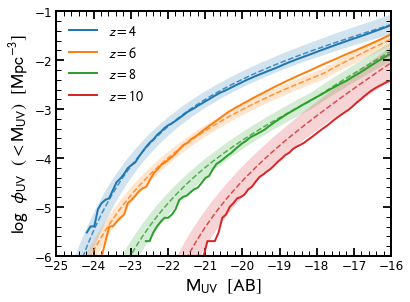

In [9]:
# check different descaling of efficiency in mergers at z=4

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))

# Observations
ax.plot(list_mag_z4, np.log10(UVLF_z4_median), '--', color='C0', alpha=0.8)
ax.fill_between(list_mag_z4, np.log10(UVLF_z4_P16), np.log10(UVLF_z4_P84), lw=0.0, color='C0', alpha=0.2)
ax.plot(list_mag_z6, np.log10(UVLF_z6_median), '--', color='C1', alpha=0.8)
ax.fill_between(list_mag_z6, np.log10(UVLF_z6_P16), np.log10(UVLF_z6_P84), lw=0.0, color='C1', alpha=0.2)
ax.plot(list_mag_z8, np.log10(UVLF_z8_median), '--', color='C2', alpha=0.8)
ax.fill_between(list_mag_z8, np.log10(UVLF_z8_P16), np.log10(UVLF_z8_P84), lw=0.0, color='C2', alpha=0.2)
ax.plot(list_mag_z10, np.log10(UVLF_z10_median), '--', color='C3', alpha=0.8)
ax.fill_between(list_mag_z10, np.log10(UVLF_z10_P16), np.log10(UVLF_z10_P84), lw=0.0, color='C3', alpha=0.2)


# Model
ax.plot(mag_bins_center_z4, np.log10(cumLF_z4), '-', color='C0', lw=2, label=r'$z=4$')
ax.plot(mag_bins_center_z6, np.log10(cumLF_z6), '-', color='C1', lw=2, label=r'$z=6$')
ax.plot(mag_bins_center_z8, np.log10(cumLF_z8), '-', color='C2', lw=2, label=r'$z=8$')
ax.plot(mag_bins_center_z10, np.log10(cumLF_z10), '-', color='C3', lw=2, label=r'$z=10$')


ax.set_xlabel(r'$\mathrm{M}_{\rm UV}\/\/\/\/[\mathrm{AB}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\phi_{\rm UV}\/\/\/\/(<\mathrm{M}_{\rm UV})\/\/\/\/[\mathrm{Mpc}^{-3}]$', fontsize=18)

ax.set_xlim([-25, -16])
ax.set_ylim([-6.0, -1.0])

plt.legend(frameon=False, fontsize=14)
plt.savefig(path_figures + 'UV_LF_evolution.pdf', bbox_inches='tight')
plt.show()


In [ ]:
# convert cumulative LF to simple LF; 
# compare with data; 
# integrate them to get UV luminosity density and compute cosmic SFRD

In [15]:
UV_mag_limit = -17.0  # Oesch+18 => but is it dust corrected?

UV_lum_density_z4 = np.interp(UV_mag_limit, mag_bins_center_z4, np.log10(cumLF_z4))
print UV_lum_density_z4


-1.55725442971


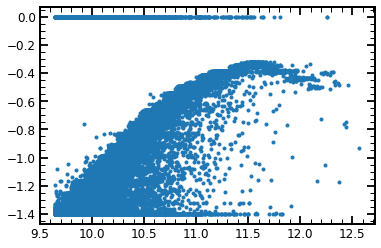

In [16]:
# check efficiency

cat_calib_z4 = h5py.File(path_SP_cat + 'SFH_z4_constant_calibration_with_L.hdf5', 'r')
ratio = cat_z4_M10['luminosities/luminosity_0'][:, 2]/cat_calib_z4['luminosities/luminosity_0'][:, 2]

plt.plot(np.log10(cat_z4['DM/DM_M'][:]), np.log10(ratio), '.')
plt.show()

# Comparison SFR Functions

In [10]:
# define functions

def compute_cumulative_SFR_fct(SFR_list, volume_box):
    '''
    input:
      prop_list:    list of luminosities or masses
      prop_bins:    bins in which number density gets calculated
      volume_box:   box size for normalisation
    '''
    idx_good = np.isfinite(SFR_list)
    SFR_list = SFR_list[idx_good]
    SFR_bins = np.arange(np.max([0.0, np.min(SFR_list)]), np.min([1000, np.max(SFR_list)]), 0.01)
    SFR_bins_center = SFR_bins[:-1] + 0.5*np.diff(SFR_bins)
    hist_zX, bin_edges = np.histogram(SFR_list, bins=SFR_bins)
    SFRFctcum = np.cumsum(hist_zX[::-1])[::-1]/(volume_box)
    return(SFR_bins_center, SFRFctcum)


def SFR_Fct_Smit16(redshift, cumulative=True, num_of_draws = 1000):
    '''
    Get SFR functions from Smit et al 2012 and 2016. 
    SFR_correction is for correcting the assumed increase of 
    0.07 dex relative to Kennicutt 98 conversion to better
    match the Ha SFR (see Smit et al 2016).
    '''
    # values from Table 2 in Smit et al 2012
    # S12
    # S_z_list = np.array([3.8, 5.0, 5.9, 6.8])
    # S_alpha_list = np.array([-1.60, -1.50, -1.57, -1.96])
    # S_phi_list = np.array([1.07, 0.76, 1.08, 0.64])*10**-3
    # S_sfr_list = np.array([1.54, 1.36, 1.07, 1.00])
    # SFR_correction = 0.0
    # S16: SMC dust from Table 6 in Smit et al 2016
    # S_z_list = np.array([3.8, 4.9, 5.9, 6.8, 7.9])
    # S_alpha_list = np.array([-1.57, -1.66, -1.72, -1.82, -1.91])
    # S_phi_list = np.array([1.76, 0.65, 0.41, 0.27, 0.18])*10**-3
    # S_sfr_list = np.array([1.41, 1.53, 1.42, 1.37, 1.19])
    # SFR_correction = 0.0
    # S16: Meurer dust from Table 8 in Smit et al 2016
    S_z_list = np.array([3.8, 4.9, 5.9, 6.8, 7.9])
    S_alpha_list = np.array([-1.53, -1.60, -1.63, -1.73, -1.85])
    S_alpha_err_list = np.array([0.05, 0.07, 0.14, 0.21, 0.38])
    S_phi_list = np.array([1.62, 0.59, 0.36, 0.23, 0.16])*10**-3
    S_phi_err_list = np.array([0.26, 0.13, 0.14, 0.13, 0.14])*10**-3
    S_sfr_list = np.array([1.74, 1.87, 1.75, 1.68, 1.43])
    S_sfr_err_list = np.array([0.07, 0.08, 0.14, 0.20, 0.38])
    SFR_correction = 0.07
    # interpolate to given redshift
    alpha = np.interp(redshift, S_z_list, S_alpha_list, left=np.nan, right=np.nan)
    phi = np.interp(redshift, S_z_list, S_phi_list, left=np.nan, right=np.nan)
    log_sfr = np.interp(redshift, S_z_list, S_sfr_list, left=np.nan, right=np.nan)
    alpha_err = np.interp(redshift, S_z_list, S_alpha_err_list, left=np.nan, right=np.nan)
    phi_err = np.interp(redshift, S_z_list, S_phi_err_list, left=np.nan, right=np.nan)
    log_sfr_err = np.interp(redshift, S_z_list, S_sfr_err_list, left=np.nan, right=np.nan)
    # draw random values from error distribution
    SFR_list = np.logspace(-1.0, 3.0, num=1000)
    alpha_draws = np.random.normal(loc=alpha, scale=alpha_err, size=num_of_draws)
    phi_draws = np.random.normal(loc=phi, scale=phi_err, size=num_of_draws)
    log_sfr_draws = np.random.normal(loc=log_sfr, scale=log_sfr_err, size=num_of_draws)
    # compute SFR function
    SFR_fct_list = []
    ii = 0 
    SFR_fct_list = phi_draws[ii]*np.power(SFR_list/10**log_sfr_draws[ii], alpha_draws[ii])*np.exp(-1.0*SFR_list/10**log_sfr_draws[ii])*1.0/10**log_sfr_draws[ii]
    for ii in np.arange(1, num_of_draws):
        SFR_fct = phi_draws[ii]*np.power(SFR_list/10**log_sfr_draws[ii], alpha_draws[ii])*np.exp(-1.0*SFR_list/10**log_sfr_draws[ii])*1.0/10**log_sfr_draws[ii]
        SFR_fct_list = np.vstack([SFR_fct_list, SFR_fct])
    SFR_fct_median = np.percentile(SFR_fct_list, 50, axis=0)
    SFR_fct_P16 = np.percentile(SFR_fct_list, 16, axis=0)
    SFR_fct_P84 = np.percentile(SFR_fct_list, 84, axis=0)
    if cumulative:
        SFR_fct_cum_median = []
        SFR_fct_cum_P16 = []
        SFR_fct_cum_P84 = []
        for ii_sfr in SFR_list:
            idx = (SFR_list > ii_sfr)
            SFR_fct_cum_median = np.append(SFR_fct_cum_median, np.trapz(SFR_fct_median[idx], SFR_list[idx]))
            SFR_fct_cum_P16 = np.append(SFR_fct_cum_P16, np.trapz(SFR_fct_P16[idx], SFR_list[idx]))
            SFR_fct_cum_P84 = np.append(SFR_fct_cum_P84, np.trapz(SFR_fct_P84[idx], SFR_list[idx]))
        return(SFR_list/10**SFR_correction, SFR_fct_cum_median, SFR_fct_cum_P16, SFR_fct_cum_P84)
    else:
        return(SFR_list/10**SFR_correction, SFR_fct_median, SFR_fct_P16, SFR_fct_P84)
    


In [11]:
# read in model
# take average SFR over past 200 Myr (UV SFR)

cat_z4 = h5py.File(path_SP_cat + 'SFH_z4_constant_with_L.hdf5', 'r')
cat_z6 = h5py.File(path_SP_cat + 'SFH_z6_constant_with_L.hdf5', 'r')
cat_z8 = h5py.File(path_SP_cat + 'SFH_z8_constant_with_L.hdf5', 'r')
cat_z10 = h5py.File(path_SP_cat + 'SFH_z10_constant_with_L.hdf5', 'r')

SFR_bins_center_z4, SFR_fct_model_z4 = compute_cumulative_SFR_fct(np.median(cat_z4['SFH/SFH_SFR'][:, (cat_z4['SFH/SFH_time'][:] >= (cat_z4['SFH/SFH_time'][:][-1]-200.0))], axis=1), volume_box)
SFR_bins_center_z6, SFR_fct_model_z6 = compute_cumulative_SFR_fct(np.median(cat_z6['SFH/SFH_SFR'][:, (cat_z6['SFH/SFH_time'][:] >= (cat_z6['SFH/SFH_time'][:][-1]-200.0))], axis=1), volume_box)
SFR_bins_center_z8, SFR_fct_model_z8 = compute_cumulative_SFR_fct(np.median(cat_z8['SFH/SFH_SFR'][:, (cat_z8['SFH/SFH_time'][:] >= (cat_z8['SFH/SFH_time'][:][-1]-200.0))], axis=1), volume_box)
SFR_bins_center_z10, SFR_fct_model_z10 = compute_cumulative_SFR_fct(np.median(cat_z10['SFH/SFH_SFR'][:, (cat_z10['SFH/SFH_time'][:] >= (cat_z10['SFH/SFH_time'][:][-1]-200.0))], axis=1), volume_box)


In [12]:
# set up observations

SFR_list_z4, SFR_fct_z4, SFR_fct_z4_P16, SFR_fct_z4_P84 = SFR_Fct_Smit16(4.0, cumulative=True)
SFR_list_z6, SFR_fct_z6, SFR_fct_z6_P16, SFR_fct_z6_P84 = SFR_Fct_Smit16(6.0, cumulative=True)
SFR_list_z8, SFR_fct_z8, SFR_fct_z8_P16, SFR_fct_z8_P84 = SFR_Fct_Smit16(7.9, cumulative=True)


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/

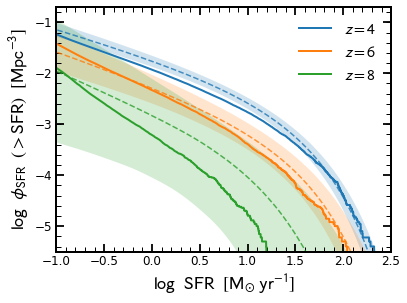

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))

# Observations
ax.plot(np.log10(SFR_list_z4), np.log10(SFR_fct_z4), '--', color='C0', alpha=0.8)
ax.fill_between(np.log10(SFR_list_z4), np.log10(SFR_fct_z4_P16), np.log10(SFR_fct_z4_P84), lw=0.0, color='C0', alpha=0.2)
ax.plot(np.log10(SFR_list_z6), np.log10(SFR_fct_z6), '--', color='C1', alpha=0.8)
ax.fill_between(np.log10(SFR_list_z6), np.log10(SFR_fct_z6_P16), np.log10(SFR_fct_z6_P84), lw=0.0, color='C1', alpha=0.2)
ax.plot(np.log10(SFR_list_z8), np.log10(SFR_fct_z8), '--', color='C2', alpha=0.8)
ax.fill_between(np.log10(SFR_list_z8), np.log10(SFR_fct_z8_P16), np.log10(SFR_fct_z8_P84), lw=0.0, color='C2', alpha=0.2)

# Model
ax.plot(np.log10(SFR_bins_center_z4), np.log10(SFR_fct_model_z4), '-', color='C0', lw=2, label=r'$z=4$')
ax.plot(np.log10(SFR_bins_center_z6), np.log10(SFR_fct_model_z6), '-', color='C1', lw=2, label=r'$z=6$')
ax.plot(np.log10(SFR_bins_center_z8), np.log10(SFR_fct_model_z8), '-', color='C2', lw=2, label=r'$z=8$')

ax.set_xlabel(r'$\log\/\/\/\/\mathrm{SFR}\/\/\/\/[\mathrm{M_{\odot}}\/\/\mathrm{yr}^{-1}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\phi_{\rm SFR}\/\/\/\/(>\mathrm{SFR})\/\/\/\/[\mathrm{Mpc}^{-3}]$', fontsize=18)

ax.set_xlim([-1.0, 2.5])
ax.set_ylim([-5.5, -0.7])

plt.legend(frameon=False, fontsize=16)
plt.savefig(path_figures + 'SFR_Fct_evolution.pdf', bbox_inches='tight')
plt.show()

# Comparison Cosmic SFR Density

In [43]:
# Oesch+18 integrates down to 0.3 Msun/yr, which corresponds to -17.0 mag
# this is probably not dust corrected, i.e. LF are integrated down to this magnitude
# we work with dust corrected quantities, i.e. we have to know to which dust corrected
# magnitude -17.0 goes to

def convert_mag_to_SFR(UVmag):
    Kuv_Oesch18 = 1.15*10**-28  # Msun/yr / erg/s/Hz
    L_1500 = np.power(10, -0.4*(UVmag+48.6))*4*np.pi*(3.086e+19)**2
    SFR = Kuv_Oesch18*L_1500
    return(SFR)
    


In [44]:
print 'mag=-17.0 in SFR:', np.round(convert_mag_to_SFR(-17.0), 2)

mag_limit_z4 = add_dust(-17.0, 4.0)
mag_limit_z6 = add_dust(-17.0, 6.0)
mag_limit_z8 = add_dust(-17.0, 8.0)
mag_limit_z10 = add_dust(-17.0, 10.0)

print convert_mag_to_SFR(mag_limit_z4)
print convert_mag_to_SFR(mag_limit_z6)
print convert_mag_to_SFR(mag_limit_z8)
print convert_mag_to_SFR(mag_limit_z10)


mag=-17.0 in SFR: 0.32
[ 0.23941016]
[ 0.31528227]
[ 0.31528227]
[ 0.31528227]


In [45]:
add_dust(-17.0, 6.0)

array([-17.])

/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in log10


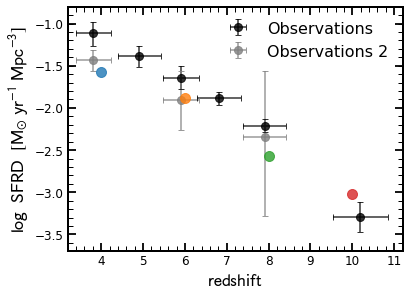

In [47]:
# integrate LF down to SFR ~ 0.3 Msun/year ??
# check IMF
# get data

SFR_limit = 0.3  # dust correction??

# Oesch+18
z_list_obs = np.array([3.804, 4.902, 5.916, 6.805, 7.907, 10.195])
z_list_obs_low = np.array([3.396, 4.395, 5.487, 6.288, 7.391, 9.542])
z_list_obs_high = np.array([4.228, 5.426, 6.327, 7.335, 8.425, 10.860])
cSFRD_obs = np.array([-1.116, -1.389, -1.647, -1.880, -2.211, -3.289])
cSFRD_obs_low = np.array([-0.986, -1.267, -1.501, -1.811, -2.132, -3.112])
cSFRD_obs_high = np.array([-1.265, -1.517, -1.781, -1.965, -2.284, -3.471])

# Smit+16
idx_S16 = np.array([True, False, True, False, True, False])
cSFRD_obs_S16 = np.array([np.log10(SFR_fct_z4[np.abs(np.log10(SFR_list_z4)-np.log10(SFR_limit)).argmin()]), np.log10(SFR_fct_z6[np.abs(np.log10(SFR_list_z6)-np.log10(0.3)).argmin()]), np.log10(SFR_fct_z8[np.abs(np.log10(SFR_list_z8)-np.log10(0.3)).argmin()])])
cSFRD_obs_low_S16 = np.array([np.log10(SFR_fct_z4_P16[np.abs(np.log10(SFR_list_z4)-np.log10(SFR_limit)).argmin()]), np.log10(SFR_fct_z6_P16[np.abs(np.log10(SFR_list_z6)-np.log10(0.3)).argmin()]), np.log10(SFR_fct_z8_P16[np.abs(np.log10(SFR_list_z8)-np.log10(0.3)).argmin()])])
cSFRD_obs_high_S16 = np.array([np.log10(SFR_fct_z4_P84[np.abs(np.log10(SFR_list_z4)-np.log10(SFR_limit)).argmin()]), np.log10(SFR_fct_z6_P84[np.abs(np.log10(SFR_list_z6)-np.log10(0.3)).argmin()]), np.log10(SFR_fct_z8_P84[np.abs(np.log10(SFR_list_z8)-np.log10(0.3)).argmin()])])


# make figure

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4.5))

# Observations
ax.errorbar(z_list_obs, cSFRD_obs, xerr=[z_list_obs-z_list_obs_low, z_list_obs_high-z_list_obs], yerr=[cSFRD_obs-cSFRD_obs_low, cSFRD_obs_high-cSFRD_obs], fmt='o', ms=8, capsize=3.0, color='black', alpha=0.8, label='Observations')
ax.errorbar(z_list_obs[idx_S16], cSFRD_obs_S16, xerr=[z_list_obs[idx_S16]-z_list_obs_low[idx_S16], z_list_obs_high[idx_S16]-z_list_obs[idx_S16]], yerr=[cSFRD_obs_S16-cSFRD_obs_low_S16, cSFRD_obs_high_S16-cSFRD_obs_S16], fmt='o', ms=8, capsize=3.0, color='gray', alpha=0.8, label='Observations 2')

# Model
ax.plot(4.0, np.log10(SFR_fct_model_z4)[np.abs(np.log10(SFR_bins_center_z4)-np.log10(SFR_limit)).argmin()], 'o', alpha=0.8, ms=10, zorder=10)
ax.plot(6.0, np.log10(SFR_fct_model_z6)[np.abs(np.log10(SFR_bins_center_z6)-np.log10(SFR_limit)).argmin()], 'o', alpha=0.8, ms=10, zorder=10)
ax.plot(8.0, np.log10(SFR_fct_model_z8)[np.abs(np.log10(SFR_bins_center_z8)-np.log10(SFR_limit)).argmin()], 'o', alpha=0.8, ms=10, zorder=10)
ax.plot(10.0, np.log10(SFR_fct_model_z10)[np.abs(np.log10(SFR_bins_center_z10)-np.log10(SFR_limit)).argmin()], 'o', alpha=0.8, ms=10, zorder=10)


ax.set_xlabel(r'$\mathrm{redshift}$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\mathrm{SFRD}\/\/\/\/[\mathrm{M_{\odot}}\/\/\mathrm{yr}^{-1}\/\/\mathrm{Mpc}^{-3}]$', fontsize=18)

ax.set_xlim([3.2, 11.2])
ax.set_ylim([-3.7, -0.8])

plt.legend(frameon=False, fontsize=16)
plt.savefig(path_figures + 'cSFRD_evolution.pdf', bbox_inches='tight')
plt.show()

